In [64]:
%matplotlib inline 

import pandas as pd
import utilities.misc as um
import utilities.constants as uc
import utilities.display as ud
import numpy as np
import matplotlib.pyplot as plt
import datetime

from twitter_api.twitter_api import get_all_tweets_from_friends

import re
import feather

from nltk_wrapper.nltk_wrapper import get_sentiment, clean_tokenize

from blp.bdx import bdh
from wordcloud import WordCloud

In [89]:
#load the data
path="D:\\data\\twitter\\"
hash_all=feather.read_dataframe(path+'hash.feather').set_index('hashtag')
study=feather.read_dataframe(path+'text.feather')
words=feather.read_dataframe(path+'words.feather')
words['word']=words['word'].map(lambda x: x.lower())

In [152]:
# set word cloud constants
wc_english=WordCloud(
        background_color='black',
        #mask=backgroup_mask,   
        max_words=1000,
        #font_path='D:\\data\\weibo\\stfangsong\\chinese.stfangso.ttf',
        max_font_size=100,
        colormap='hsv')

In [54]:
# plot blog vs market, and add an embedded plot to show the word cloud
nice_name={'SHSZ300 Index':'CSI300','SH000905 Index':'CSI500','SZ399006 Index':'ChiNext','HSCEI Index':'HSCEI'}
nice_order=['CSI300','ChiNext','HSCEI']
mkt=bdh(list(nice_name.keys()),['PX_LAST'],pd.datetime(2019,12,1),um.today_date())
mkt=mkt['PX_LAST'].unstack().T
mkt=mkt/mkt.iloc[0]
mkt=mkt.rename(columns=nice_name)
mkt=mkt[nice_order].fillna(method='ffill')

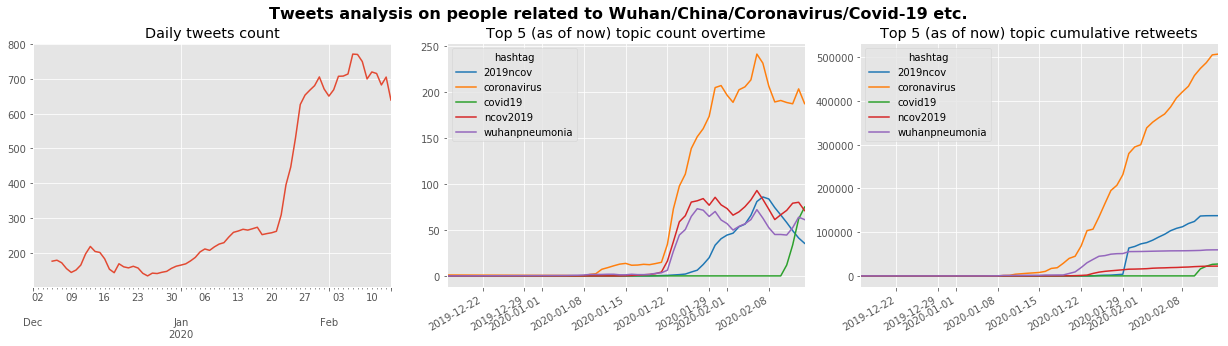

In [55]:
# show tweet count and hashtag trend
n_topic=5
hash_to_use=hash_all.copy()
hash_to_use.index=hash_to_use.index.map(lambda x: re.sub("([^\x00-\x7F])+","",x).lower())
hash_to_choose=hash_to_use.reset_index().groupby(['date','hashtag']).count()['likes'].unstack().mean().dropna().sort_values().iloc[-n_topic:].index
hash_to_plot=hash_to_use.loc[hash_to_choose].reset_index()

# plot
fig,axes=ud.easy_plot_quick_subplots((1,3),'Tweets analysis on people related to Wuhan/China/Coronavirus/Covid-19 etc.')
color=[uc.alt_colors_quick_pd_plot[i*2] for i in np.arange(0,n_topic)]
study.groupby(['date']).count()['user_id'].rolling(5,min_periods=5).mean().plot(ax=axes[0],title='Daily tweets count')
(hash_to_plot.reset_index().groupby(['date','hashtag']).count().unstack().fillna(0).rolling(5,min_periods=1).mean()['index']
    .plot(color=color,ax=axes[1],title='Top %s (as of now) topic count overtime' % (n_topic)))

(hash_to_plot.reset_index().groupby(['date','hashtag']).sum()['retweets'].unstack().fillna(0).cumsum()
    .plot(color=color,ax=axes[2],title='Top %s (as of now) topic cumulative retweets' % (n_topic)))

for i in [0,1,2]:
    axes[i].set_xlabel('')

# Text processing related
- Pre-process
    - Tokenization (sentence and word)
    - Drop stop words
    - Lexicon normalization (stemming (connection/conneting --> connect) and lemmatization (better/best --> good))
- How to train your own sentiment classifier? (one way)
    - You need to have a already tagged data (e.g. from nltk.twitter)
    - Then you create the bag of words (BoW)
    - With BoW you create TF-IDF (some kind of normalized BoW)
    - Feed the matrix to ML algo (row is text_i, coloumn is word), Y is the already-tagged score
    - Make prediction
    - limitation: no idea of context only focusing on the word
- In reality, we just use Vader (get the compound output) which is suited for social media. We only need text processing for word cloud



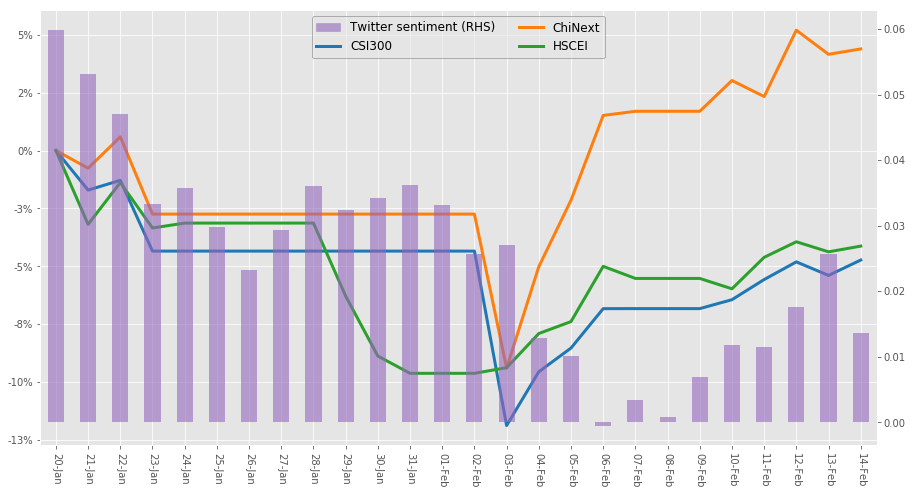

In [63]:
#sentiment vs market
topic_i='Twitter sentiment'

sentiment=study.groupby('date')['sentiment'].mean().rolling(5,min_periods=1).mean().rename(topic_i)

to_plot=pd.concat([sentiment,mkt],axis=1).loc[pd.datetime(2020,1,20):]
to_plot[nice_order]=to_plot[nice_order]/to_plot[nice_order].iloc[0]
to_plot[nice_order]=to_plot[nice_order].fillna(method='ffill')
#to_plot['sentiment']=to_plot['sentiment'].fillna(0)
to_plot.index=to_plot.index.map(lambda x: x.strftime('%d-%b'))

fig,ax=plt.subplots(1,1,figsize=(15,8))
(to_plot[nice_order]-1).plot(ax=ax,legend=False,color=[uc.alt_colors_quick[x*2] for x in np.arange(0,len(nice_order))],lw=3)
ud.easy_plot_pct_tick_label(ax,direction='y')
ax_sec=ax.twinx()
to_plot[topic_i].plot(ax=ax_sec,kind='bar',alpha=0.6,color=uc.alt_colors_quick[8])
ax_sec.grid(False)

#adding customized legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements=[]
legend_elements.append(Patch(facecolor=uc.alt_colors_quick[8], edgecolor=uc.alt_colors_quick[8],alpha=0.6,label=topic_i+' (RHS)'))
for i,mkt_i in enumerate(nice_order):
    legend_elements.append(Line2D([0], [0], color=uc.alt_colors_quick[i*2], lw=3, label=mkt_i))
ax.legend(handles=legend_elements, loc='upper center',framealpha=0.5,fancybox=True,fontsize=12,ncol=2).get_frame().set_edgecolor('k')

ax.tick_params(axis="x",  rotation=270)

In [169]:
# daily tweets count vs. word cloud overtime
top_pct=0.9
min_freq=5
manual_filter=['https','rt','s','amp','drtedros','...','nt','like','one','1','2','3','get']
manual_modify={'hong':'hong kong','kong':'hong kong'}


start_date=pd.datetime(2019,12,11)
key_periods={'Almost no discussion':[start_date,pd.datetime(2019,12,30),4],
            'Quick incrase in public attention':[pd.datetime(2019,12,30),pd.datetime(2020,1,19),2],
             'Full public attention':[pd.datetime(2020,1,19),um.today_date(),6],            
            }
periods=['Almost no discussion','Quick incrase in public attention','Full public attention']

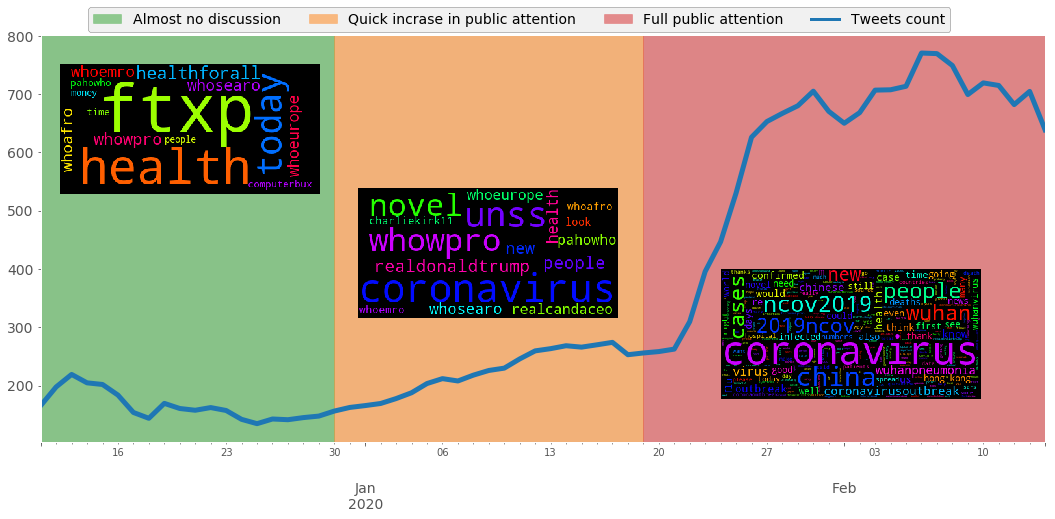

In [172]:
# now we do an embedded plot
# need to adjust the location of the sub-ax


fig, ax = plt.subplots(1,1,figsize=(18,7.5))
wb_count_to_plot=study.groupby(['date']).count()['user_id'].rolling(5,min_periods=5).mean().loc[start_date:].plot(ax=ax,lw=5,color=uc.alt_colors_quick[0])
ax.set_xlabel('')
ax.grid(False)
legend_elements=[]


for period in periods:
    info_i=key_periods[period]
    start_i=info_i[0]
    end_i=info_i[1]
    color_i=info_i[2]
    
    ax.axvspan(start_i, end_i, alpha=0.5, color=uc.alt_colors_quick[color_i])
    
    wc_to_use=wc_english
    
    legend_elements.append(Patch(facecolor=uc.alt_colors_quick[color_i], edgecolor=uc.alt_colors_quick[color_i],alpha=0.5,label=period))
    
legend_elements.append(Line2D([0], [0], color=uc.alt_colors_quick[0], lw=3, label='Tweets count'))
ax.legend(handles=legend_elements, loc='upper left',framealpha=0.5,fancybox=True,fontsize=14,ncol=4,
         bbox_to_anchor=(0.04,1.085)).get_frame().set_edgecolor('k')
ax.tick_params(axis='both', which='major', labelsize=14)


# sub axes
left, bottom, width, height = [0.14, 0.58, 0.2, 0.25]
ax_1 = fig.add_axes([left, bottom, width, height])

left, bottom, width, height = [0.37, 0.35, 0.2, 0.25]
ax_2 = fig.add_axes([left, bottom, width, height])

left, bottom, width, height = [0.65, 0.2, 0.2, 0.25]
ax_3 = fig.add_axes([left, bottom, width, height])

sub_axes=[ax_1,ax_2,ax_3]

for i,period in enumerate(periods):
    info_i=key_periods[period]
    start_i=info_i[0]
    end_i=info_i[1]
    color_i=info_i[2]
    
    words_i=words[(words['date']>=start_i) &(words['date']<=end_i)].copy()
    words_i['word']=words_i.set_index('word').rename(index=manual_modify).reset_index()
    freq=words_i.groupby('word').count().sort_values(by='date',ascending=False).drop(manual_filter)['date']
    freq_to_show=freq[freq>=min_freq].rank(pct=True)
    freq_to_show=freq_to_show[freq_to_show>=top_pct]
    wc_freq=freq.loc[freq_to_show.index].to_dict()
    
    word_cloud =wc_to_use.generate_from_frequencies(wc_freq)
    
    sub_axes[i].imshow(word_cloud)
    sub_axes[i].axis("off")

